## CX4240 project

## Classification of Acute Lymphoblastic Leukemia (ALL) in Blood Cell Images Using Machine Learning

# Dimension Reduction

In [38]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv 
import matplotlib as mpl
import plotly 
plotly.tools.set_credentials_file(username='JC-Chun', api_key='WXQ9jdGdWhUznzK2PZ50')
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls

from IPython.display import IFrame
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

%matplotlib inline


## Load Images

In [5]:
train_df = pd.read_csv('Data/train_data.csv')
train = pd.DataFrame.as_matrix(train_df)
test = pd.DataFrame.as_matrix(pd.read_csv('Data/test_data.csv'))
train_data = train[:,2:]
label_train = train[:,1].astype(int)
test_data = test[:,2:]
label_test = test[:,1].astype(int)
features = list(train_df.columns[2:]) 
print(np.shape(train_data))
print(np.shape(test_data))
n_ALL = 7272
n_hem = 3389
D = len(features)
features

(10661, 38)
(1867, 38)


C:\Users\1000j\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\1000j\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


['Cell Size',
 'Perimeter',
 'Form Factor',
 'Roundness',
 'Length/Diameter Ratio',
 'Compactness',
 'Boundary Roughness Variance',
 'Boundary Roughness Skewness',
 'Boundary Roughness Kurtosis',
 'Haralick Angular Second Moment',
 'Haralick Contrast',
 'Haralick Correlation',
 'Haralick Variance',
 'Haralick Inverse Difference Moment',
 'Haralick Sum Average',
 'Haralick Sum Variance',
 'Haralick Sum Entropy',
 'Haralick Entropy',
 'Haralick Difference Variance',
 'Haralick Difference Entropy',
 'Haralick Information Measures of Correlation 1',
 'Haralick Information Measures of Correlation 2',
 'Wavelet Approximation Mean',
 'Wavelet Horizontal Mean',
 'Wavelet Vertical Mean',
 'Wavelet Diagonal Mean',
 'Wavelet Approximation Variance',
 'Wavelet Horizontal Variance',
 'Wavelet Vertical Variance',
 'Wavelet Diagonal Variance',
 'Red Mean',
 'Green Mean',
 'Blue Mean',
 'Hue Mean',
 'Saturation Mean',
 'Value Mean',
 'Intensity Mean',
 'Intensity Variance']

## Dimension Reduction Using Random Forest

Feature ranking:
1. F1: Cell Size (0.176257)
2. F2: Perimeter (0.116350)
3. F38: Intensity Variance (0.033516)
4. F31: Red Mean (0.030619)
5. F36: Value Mean (0.030509)
6. F34: Hue Mean (0.029441)
7. F35: Saturation Mean (0.029183)
8. F33: Blue Mean (0.025258)
9. F32: Green Mean (0.024701)
10. F3: Form Factor (0.024108)
11. F37: Intensity Mean (0.022947)
12. F23: Wavelet Approximation Mean (0.021114)
13. F15: Haralick Sum Average (0.020327)
14. F7: Boundary Roughness Variance (0.019356)
15. F14: Haralick Inverse Difference Moment (0.018967)
16. F19: Haralick Difference Variance (0.018572)
17. F8: Boundary Roughness Skewness (0.017622)
18. F29: Wavelet Vertical Variance (0.017592)
19. F20: Haralick Difference Entropy (0.017527)
20. F5: Length/Diameter Ratio (0.017369)
21. F28: Wavelet Horizontal Variance (0.017287)
22. F6: Compactness (0.017183)
23. F21: Haralick Information Measures of Correlation 1 (0.017172)
24. F9: Boundary Roughness Kurtosis (0.016857)
25. F30: Wavelet Diagonal Var

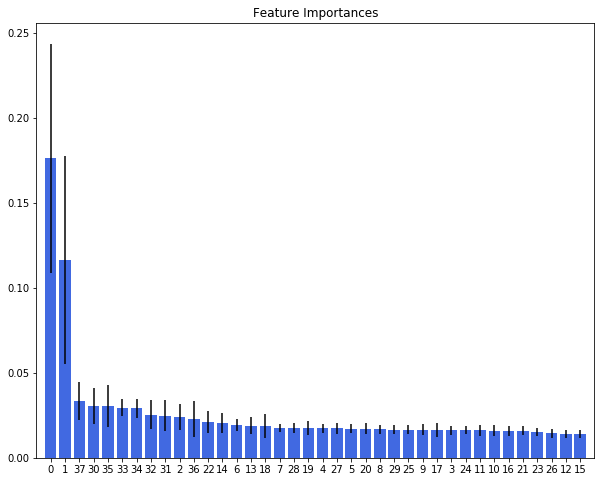

The number of components:  38


In [19]:
# Finding the most important features using Random Forest
forest = ExtraTreesClassifier(n_estimators=100, random_state=0)
label_train = np.concatenate(([1]*n_ALL, [0]*n_hem), axis=0) # labels: 1=ALL  0=hem
forest.fit(train_data, label_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for i in range(train_data.shape[1]):
    print("%d. F%d: %s (%f)" % (i + 1, indices[i]+1, features[indices[i]], importances[indices[i]]))

# Plot the feature importances of the forest
plt.figure(figsize=(10,8))
plt.title("Feature Importances")
plt.bar(range(train_data.shape[1]), importances[indices],
        color="royalblue", yerr=std[indices], align="center")
plt.xticks(range(train_data.shape[1]), indices)
plt.xlim([-1, train_data.shape[1]])
plt.show()

# Find the number of components
cum_importance = importances[indices].cumsum()/importances.sum()
n_components = np.sum(cum_importance < .99) + 1
print("The number of components: ", n_components)

In [27]:
# Reduce train data to the first 16 important features
n_features = 16
RF_train_data = train_data[:,indices[:n_features]]

# Conversion of data from numpy array to dataframe
RF_train_data_df = pd.DataFrame.from_records(RF_train_data)
RF_train_data_df.columns = tuple(features[i] for i in indices[:n_features])
label_train = np.concatenate(([1]*n_ALL,[0]*n_hem), axis=0) 
RF_train_data_df.insert(0,"Label",label_train,True)
RF_train_data_df

# save train_data_df as a csv file
RF_train_data_df.to_csv('Data/RF_train_data')
RF_train_data_df

,Label,Cell Size,Perimeter,Intensity Variance,Red Mean,Value Mean,Hue Mean,Saturation Mean,Blue Mean,Green Mean,Form Factor,Intensity Mean,Wavelet Approximation Mean,Haralick Sum Average,Boundary Roughness Variance,Haralick Inverse Difference Moment,Haralick Difference Variance
0,1,0.759138,0.346510,0.085723,0.594745,0.592866,0.500383,0.524491,0.571364,0.465774,0.628346,0.519285,0.407731,0.406689,0.023505,0.660415,0.329463
1,1,0.900155,0.797309,0.222945,0.605701,0.650349,0.667944,0.194729,0.649440,0.689613,0.085665,0.656860,0.465373,0.465032,0.386746,0.477701,0.197532
2,1,0.986792,0.745164,0.237267,0.653997,0.700716,0.666517,0.130090,0.697265,0.764662,0.152404,0.718251,0.361896,0.361437,0.370793,0.576768,0.300586
3,1,0.927033,0.705635,0.208014,0.601589,0.673983,0.746100,0.188885,0.680266,0.718083,0.163153,0.682306,0.438521,0.437071,0.288998,0.496607,0.257627
4,1,0.570993,0.234651,0.133042,0.697305,0.690830,0.415967,0.481193,0.610590,0.553968,0.791883,0.590725,0.412503,0.410746,0.013297,0.614777,0.311138
5,1,0.833722,0.514718,0.207710,0.859595,0.858556,0.505065,0.171900,0.811140,0.861802,0.335705,0.838909,0.631828,0.628974,0.126950,0.390705,0.077540
6,1,0.629159,0.450799,0.166442,0.672963,0.673115,0.407798,0.380517,0.587634,0.596984,0.301368,0.598034,0.575345,0.573712,0.176602,0.390198,0.130978
7,1,0.566606,0.212784,0.155884,0.569758,0.569615,0.412141,0.544513,0.502893,0.444619,0.881007,0.477914,0.368007,0.365952,0.003795,0.535928,0.215391
8,1,0.887755,0.538267,0.250340,0.661549,0.675714,0.511647,0.310690,0.624681,0.645778,0.332038,0.634284,0.431220,0.429314,0.255072,0.544468,0.244521
9,1,0.696377,0.269975,0.129563,0.684415,0.692643,0.570037,0.468073,0.686697,0.562400,0.816091,0.624107,0.491402,0.491310,0.006824,0.479221,0.206388


/Users/pdgalonsky/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/pdgalonsky/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


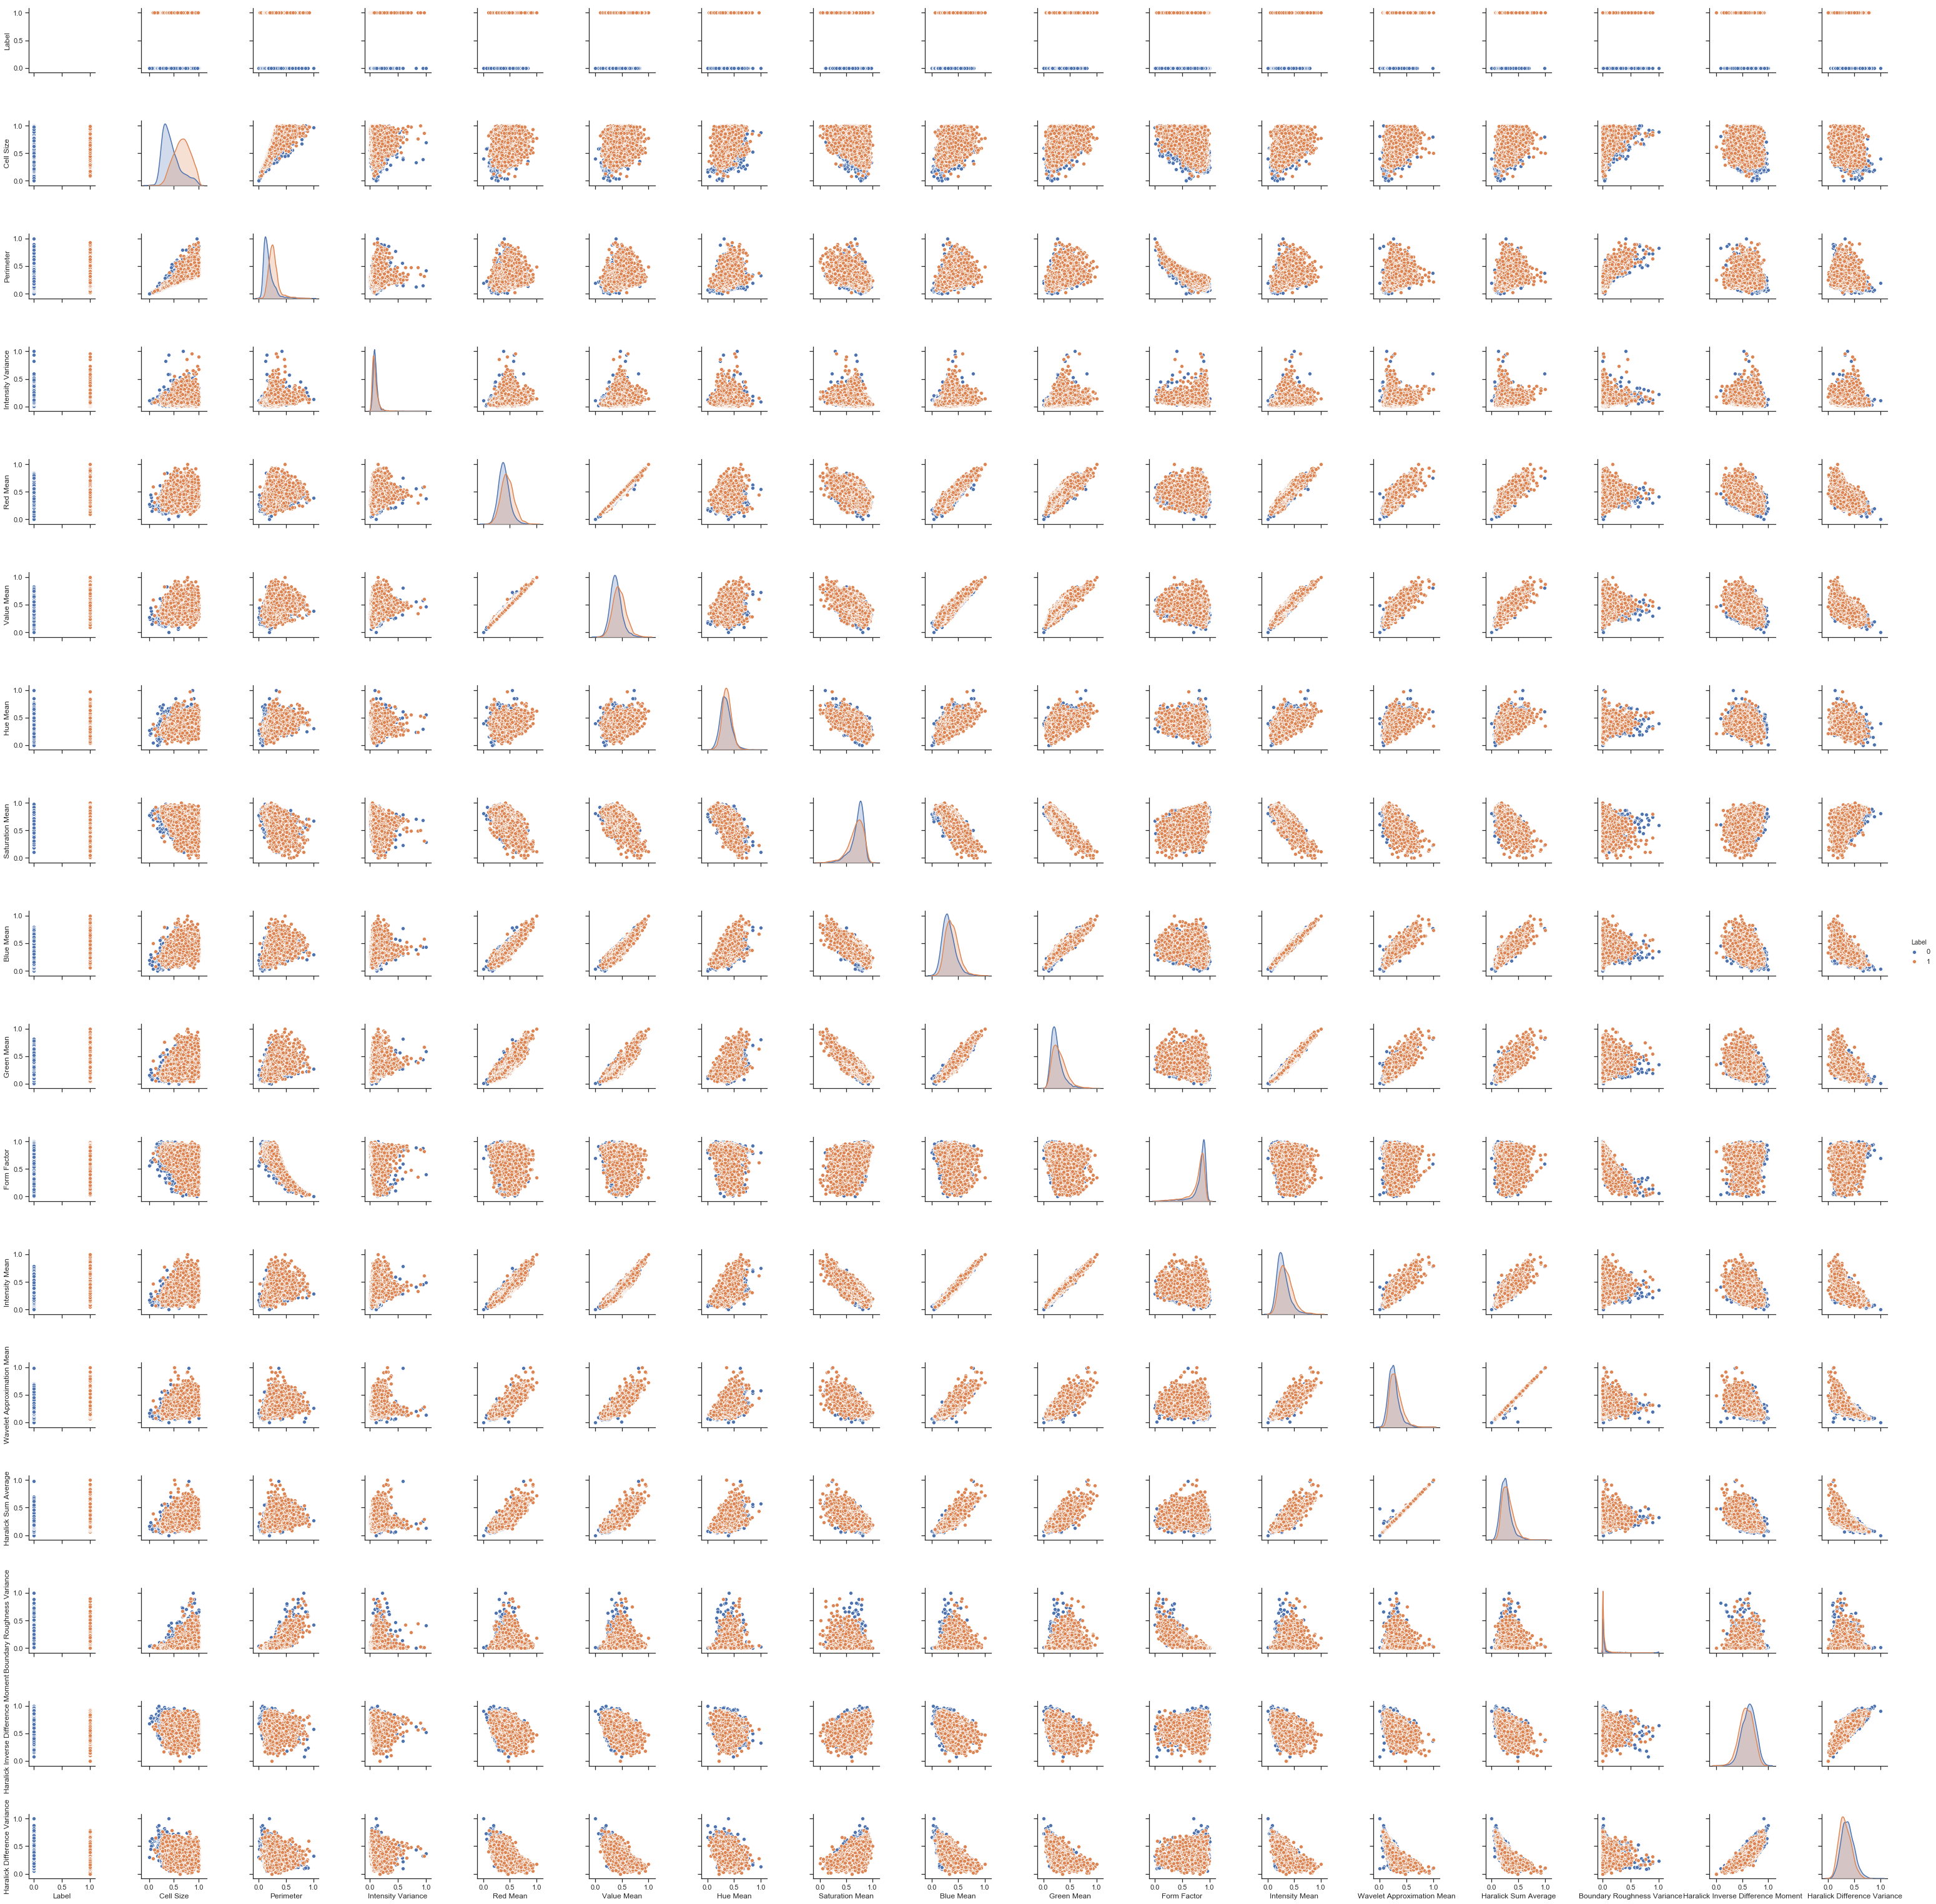

In [25]:
# Data visualization
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(RF_train_data_df,hue="Label")

Text(0.5, 0, 'Value Mean')

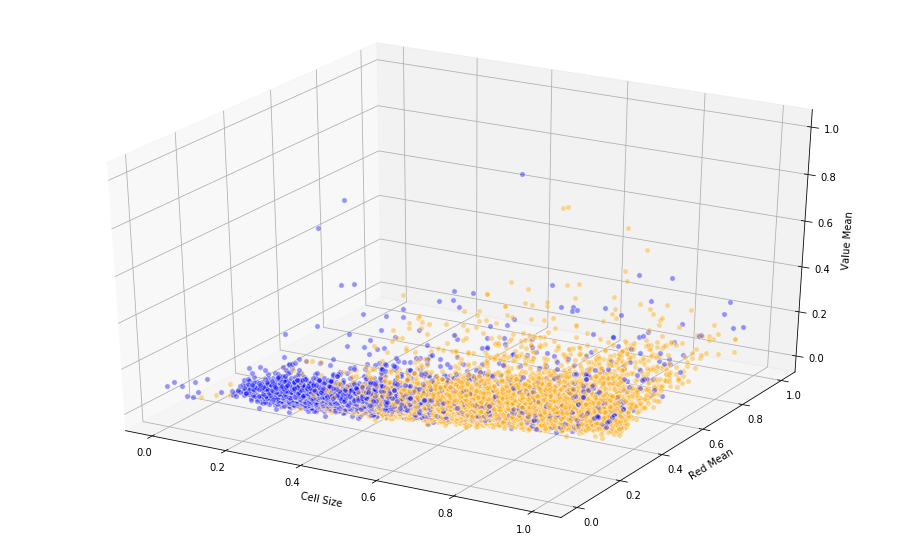

In [43]:
# Visualizing 3-D numeric data with Scatter Plots
# length, breadth and depth
df = RF_train_data_df.sample(frac=1)
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')
xs = list(RF_train_data_df['Cell Size'])
ys = list(RF_train_data_df['Perimeter'])
zs = list(RF_train_data_df['Intensity Variance'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['orange' if i == 1 else 'blue' for i in list(RF_train_data_df['Label'])]
for data, color in zip(data_points, colors):
    x, y, z = data
    ax.scatter(x, y, z,s=30, alpha=0.4, c=color, edgecolors='w')

ax.set_xlabel('Cell Size')
ax.set_ylabel('Perimeter')
ax.set_zlabel('Intensity Variance')

In [50]:
# Visualization with Plotly
# Trace of ALL
ALL = go.Scatter3d(
        x = xs[:n_ALL],
        y = ys[:n_ALL],
        z = zs[:n_ALL],
        name = 'ALL',
        mode = 'markers',
        marker = dict(
            size = 10,
            color = 'rgb(000,102,204)'))
# Trace of hem
Normal = go.Scatter3d(
        x = xs[n_ALL:],
        y = ys[n_ALL:],
        z = zs[n_ALL:],
        name = 'Normal',
        mode = 'markers',
        marker = dict(
            size = 10,
            color = 'rgb(255,153,000)'))
data = [ALL, Normal]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-colorscale')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~JC-Chun/0 or inside your plot.ly account where it is named '3d-scatter-colorscale'


C:\Users\1000j\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [33]:
# Reduce test data to the first 16 important features
RF_test_data = test_data[:,indices[:n_features]]

# Conversion of data from numpy array to dataframe
RF_test_data_df = pd.DataFrame.from_records(RF_test_data)
RF_test_data_df.columns = tuple(features[i] for i in indices[:n_features])

# insert labels for test data 
RF_test_data_df.insert(0,"Label",label_test,True)

# save train_data_df as a csv file
RF_test_data_df.to_csv('RF_test_data')
RF_test_data_df

,Label,Cell Size,Perimeter,Intensity Variance,Red Mean,Value Mean,Hue Mean,Saturation Mean,Blue Mean,Green Mean,Form Factor,Intensity Mean,Wavelet Approximation Mean,Haralick Sum Average,Boundary Roughness Variance,Haralick Inverse Difference Moment,Haralick Difference Variance
0,1,0.883714,0.312027,0.003624,0.240324,0.238211,0.450813,0.791309,0.243038,0.127902,0.868464,0.177943,0.220035,0.218898,0.014642,0.724550,0.442925
1,1,0.609393,0.244743,0.032018,0.268241,0.264299,0.322071,0.844458,0.204609,0.121890,0.803981,0.163229,0.198414,0.198191,0.012993,0.649884,0.436436
2,1,0.990971,0.408747,0.048079,0.467291,0.461271,0.373925,0.723956,0.391821,0.282336,0.657580,0.342176,0.311684,0.310403,0.120588,0.623080,0.311750
3,0,0.665389,0.293524,0.103865,0.352083,0.360430,0.519724,0.518849,0.372233,0.321618,0.693869,0.336974,0.235865,0.234829,0.118450,0.706731,0.469913
4,1,0.469023,0.187553,0.126769,0.602013,0.594637,0.370126,0.546470,0.505918,0.458139,0.840364,0.489987,0.385518,0.383676,0.041898,0.499379,0.253902
5,1,0.643129,0.240538,0.034180,0.403336,0.396680,0.272198,0.788365,0.285129,0.214987,0.868063,0.258452,0.257779,0.256688,0.004996,0.640905,0.397235
6,0,0.564251,0.343146,0.223074,0.501123,0.494890,0.383302,0.596494,0.429854,0.377547,0.449968,0.407505,0.278129,0.276901,0.058659,0.490170,0.301087
7,0,0.795761,0.481918,0.099255,0.570120,0.565088,0.400870,0.562057,0.495420,0.427293,0.363716,0.466608,0.455969,0.454315,0.291617,0.596199,0.286922
8,1,0.564874,0.227923,0.172509,0.552054,0.544327,0.303676,0.565960,0.439891,0.420110,0.811163,0.438080,0.333038,0.332013,0.012734,0.453960,0.262027
9,1,0.728566,0.258200,0.060509,0.406792,0.408253,0.400111,0.635304,0.357960,0.295582,0.905607,0.326673,0.289017,0.288449,0.000367,0.608060,0.316004


# Dimension Reduction Using PCA


The number of principal components necessary to recover 99% of variance: 18


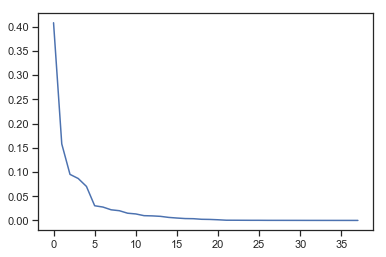

In [39]:
# Dimension reduction using PCA
D = np.size(train_data[1])
pca = PCA(n_components = D)
pca.fit(train_data)  
PCA(copy=True, iterated_power='auto', n_components = D, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False)
plt.plot(pca.explained_variance_ratio_) 
n_components = np.sum((pca.explained_variance_ratio_.cumsum()/pca.explained_variance_ratio_.sum()) < 0.99)+1
print('The number of principal components necessary to recover 99% of variance:',n_components)

In [40]:
# choose number of components from the elbow test
n_components = 6
pca = PCA(n_components=n_components)
pca.fit(train_data)  
PCA_train_data = pca.fit_transform(train_data)
print('Shape of train data: ', np.shape(PCA_train_data))
PCA_test_data = pca.transform(test_data)
PCA_test_data

Shape of train data:  (10661, 6)


array([[-0.31621096,  0.12169548, -0.11171247, -0.27908305, -0.31326517,
        -0.03952215],
       [-0.41659579, -0.018704  , -0.10967063, -0.0712254 , -0.18245497,
         0.0515183 ],
       [ 0.25733307,  0.45740716, -0.12626364, -0.07407098, -0.18682431,
        -0.20727642],
       ...,
       [ 0.1156295 , -0.11302469,  0.12574631, -0.38448912,  0.08453028,
        -0.01558871],
       [ 0.13820121, -0.46040783, -0.35990064,  0.30527009, -0.24859447,
        -0.01395055],
       [-0.10615421,  0.00794353,  0.05137154, -0.1717684 , -0.18277907,
         0.3741329 ]])

In [36]:
# Conversion of data from numpy array to dataframe
PCA_train_data_df = pd.DataFrame.from_records(PCA_train_data)
PCA_train_data_df.columns = tuple('PC'+str(num+1) for num in range(np.size(PCA_train_data[1])))
PCA_train_data_df.insert(0,"Label",label_train,True)

# save train_data_df as a csv file
PCA_train_data_df.to_csv('Data/PCA_train_data.csv')
PCA_train_data_df

,Label,PC1,PC2,PC3,PC4,PC5,PC6
0,1,0.305168,0.146328,0.429253,-0.223011,0.016387,0.141288
1,1,1.291272,0.756266,-0.171950,0.036133,0.083159,0.246935
2,1,1.157970,0.685565,0.099478,-0.219502,0.037455,0.326016
3,1,1.133667,0.900587,0.123463,0.034782,0.101921,0.207056
4,1,0.393299,0.048422,0.444055,-0.082223,0.279378,-0.013003
5,1,1.525858,0.180044,0.177779,0.056508,0.234650,0.128906
6,1,1.092496,0.268410,-0.164498,0.254831,0.248916,0.136796
7,1,0.394921,-0.371567,0.022566,-0.077390,0.111413,0.034685
8,1,1.077061,0.643260,-0.132883,0.003546,0.193306,0.039842
9,1,0.768358,-0.314252,0.175211,-0.130853,0.132358,-0.011269


Text(0.5, 0, 'PC3')

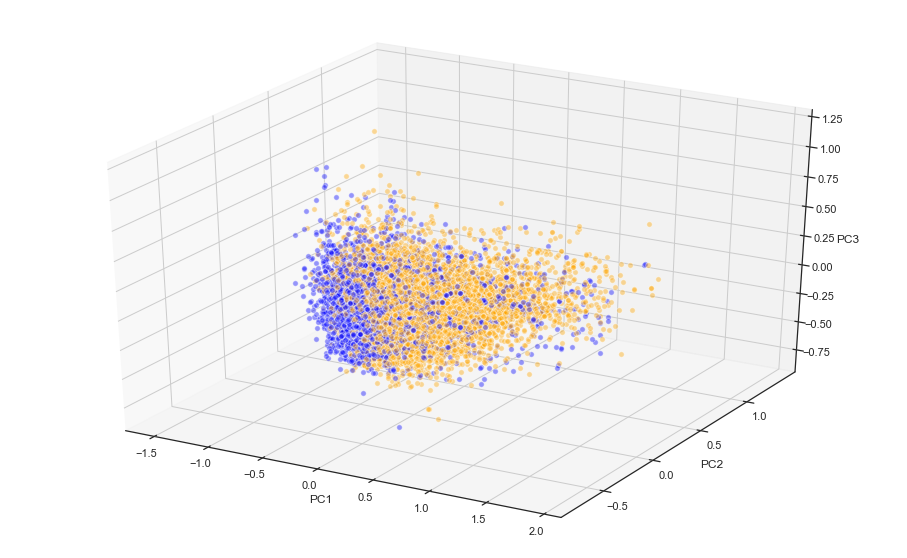

In [37]:
# Visualizing 3-D numeric data with Scatter Plots
# PC1, PC2 and PC3
df = PCA_train_data_df.sample(frac=1)
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')
xs = list(PCA_train_data_df['PC1'])
ys = list(PCA_train_data_df['PC2'])
zs = list(PCA_train_data_df['PC3'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['orange' if i == 1 else 'blue' for i in list(RF_train_data_df['Label'])]
for data, color in zip(data_points, colors):
    x, y, z = data
    ax.scatter(x, y, z,s=30, alpha=0.4, c=color, edgecolors='w')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

In [38]:
# Conversion of data from numpy array to dataframe
PCA_test_data_df = pd.DataFrame.from_records(PCA_test_data)
PCA_test_data_df.columns = tuple('PC'+str(num+1) for num in range(np.size(PCA_test_data[1])))

# insert labels for test data 
PCA_test_data_df.insert(0,"Label",label_test,True)

# save test_data_df as a csv file
PCA_test_data_df.to_csv('Data/PCA_test_data.csv')
PCA_test_data_df

,Label,PC1,PC2,PC3,PC4,PC5,PC6
0,1,-0.316211,0.121695,-0.111712,-0.279083,-0.313265,-0.039521
1,1,-0.416596,-0.018704,-0.109671,-0.071225,-0.182455,0.051519
2,1,0.257333,0.457407,-0.126264,-0.074071,-0.186824,-0.207276
3,0,-0.098657,0.547002,0.143966,-0.032425,0.079969,-0.046849
4,1,0.424821,0.002101,0.009265,0.178515,0.311624,-0.147179
5,1,-0.251652,-0.079707,0.065530,-0.125402,-0.126333,0.049292
6,0,0.178177,0.307118,0.196866,0.243807,-0.002237,0.152616
7,0,0.514799,0.665987,0.078832,0.060241,0.064464,0.003423
8,1,0.217040,-0.074202,0.228098,0.158335,0.042431,-0.013973
9,1,0.062091,-0.287027,-0.069918,-0.220626,-0.140235,0.038804
